## Preference-based Policy Iteration Algorithm - Application on Mountain-Car Problem

This is an attempt to replicate the work done by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"

*TO-DOs:*
>- Run t-tests for pair-wise comparisons (only add preferences for significantly different pairs) -> might help to converge. -->

*ISSUES/UNCLEAR POINTS:*
>- how to handle the two state values that were not considered? (cart-position and velocity)
- how the NN (approximator) actually makes the prediction?
- how does the environment execute actions in the extended action space?

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML

import gym
from gym import wrappers

import io
import base64
import itertools
import tqdm

from scipy.stats import rankdata as rd
from scipy import stats

    Description:
    
        The agent (a car) is started at the bottom of a valley. For any given
        state the agent may choose to accelerate to the left, right or cease
        any acceleration.
        
    Source:
        The environment appeared first in Andrew Moore's PhD Thesis (1990).
        
    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
        
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
        
    Reward:
    
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
         
    Starting State:
    
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
         
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200

In [3]:
# updating the maximum length of trajectory trajectory to 1000 steps
gym.envs.register(
    id='MountainCar_PbPI_Version-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=1000,      # MountainCar-v0 uses 200
)

env = gym.make('MountainCar_PbPI_Version-v0')
env.reset()

print("Number of actions: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space))
print("Max. values of observation space:" + str(env.observation_space.high))
print("Min. values of observation space:" + str(env.observation_space.low))

Number of actions: 3
Observation space: Box(2,)
Max. values of observation space:[0.6  0.07]
Min. values of observation space:[-1.2  -0.07]


In [6]:
# helper functions
def random_action(environment):
    """ return a random action from the given environment"""
    
    action = environment.action_space.sample()  
    return action


def generate_init_states_S(env_name:'string', seed):
    """this function returns a list of randomly generated initial states from an input environment """
    
    np.random.seed(seed)
    
    n_actions = np.random.randint(low=1, high=101)                # how many actions to generate
    seq_actions = np.random.randint(low=0,high=2,size=n_actions)  # random sequence of actions

    # array to store initial states
    init_states_S = []

    # initialize environment
    env = gym.make(env_name)
    env.reset()

    # execute the randomly generated sequence of actions
    for action in seq_actions:

        state, reward, done, info = env.step(action)  
        
        init_states_S.append(state) 
    
        if done: 
            env.reset()    
            
    env.close()
            
    return init_states_S

In [6]:
# generate sample states
init_states_S = generate_init_states_S('MountainCar_PbPI_Version-v0', 20)

# display the first 10 initial states
env = gym.make('MountainCar_PbPI_Version-v0')
env = env.unwrapped # unwrap the environment to set custom initial states
fig = plt.figure(figsize=(20,10))

for i in range(20):
    env.state = init_states_S[i] # set state
    fig.add_subplot(4,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

In [13]:
def partition_action_space(env_name:'string',n_actions:'int'):
    """function to partitions the action space of an environment into a given number of actions`"""
    
    # initialize environment
    env = gym.make(env_name)
    
    actions = np.arange(env.action_space.n)

    # a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space                                                                                

In [30]:
env_name = 'MountainCar_PbPI_Version-v0'
env = gym.make(env_name)

print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env_name,3)))
print("Partitioned into 6 actions: " + str(partition_action_space(env_name,6)))

Original action space: 3
Partitioned into 3 actions: [-0.16648653  0.83351347  1.83351347]
Partitioned into 6 actions: [-0.10794132  0.29205868  0.69205868  1.09205868  1.49205868  1.89205868]


### Preference-based Approximate Policy Iteration algorithm

In [149]:
#####################################
### Evaluate-Preference procedure ###

### Functionality:
### - INPUTS  : starting state (s), two-actions(a_k, a_j), (current) policy (\pi), max. length of trajectoris (L)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)

### - Run this procedure for every action-pair at all initial-states

def evaluate_preference(starting_state # starting state of roll-outs
                        , action_1     # first action to execute at the starting-state
                        , action_2     # second action to execute at the starting state
                        , policy_in    # policy to folow
                        , environment_name = 'MountainCar_PbPI_Version-v0'   # name of the environment
                        , discount_fac = 1        # discounting factor
                        , n_rollouts = 100        # number of roll-outs to generate per action
                        , max_rollout_len = 1000  # maximum length of a roll-out
                        , label_ranker=False      # whether to use the label-ranking model or not
                        , p_sig = 0.05            # p-value to use for t-test (to compare avg. returns of roll-outs from each action)
                       ):
    
    """
    Description:
        At every state in the initial state set, roll-outs are generated by starting from each action and following the given policy.
        Accumulated rewards from each roll-out at each action are used to generate preferences for the given pair of actions.
        Preferences generated through this method are stored to create a training set to learn the label ranking model.
    
    """
    
    ### initialize local variables  ###
    
    policy = policy_in          
    n_rollouts = n_rollouts     
    gamma = discount_fac    
    s_init = starting_state
        
    actions = { 'one' : action_1    # dictionary to store input actions
              , 'two' : action_2}    

    r = { 'one' : [None]*n_rollouts # dictionary to store rewards of roll-outs, starting from each action
        , 'two' : [None]*n_rollouts}  

    avg_r = {}  # dictionary to store average discounted return for each action

    max_traj_len = max_rollout_len # maximum roll-out trajectory length

    
    # select one action from the two given action and generate roll-outs
    for action_key, action_value in actions.items():

        for rollout in range(n_rollouts):

            env = gym.make(environment_name)
            env = env.unwrapped
            
            env.state = s_init  # set the starting state

            # pre-process the action value in case the action-space is partitioned: environment only accepts discrete action values
            action_val_processed = int(abs(round(action_value)))
            observation, reward, done, info = env.step(action_val_processed)
            
            hist = observation # store the last state (observation)
            
            r[action_key][rollout] = reward  # add the immediate reward received after executing the action

            # follow the given policy to generate a roll-out trajectory 
            # until the agent meets a terminal state or exceeds the max. trajectory length is exceeded
            traj_len = 1
            while traj_len < max_traj_len and not done: 
                
                
                if label_ranker: # if the policy should be derived from the label-ranking model
                    observation, reward, done, info = env.step(policy.label_ranking_policy(hist))
                    hist = observation
                    
                else: # if the policy should be derived from a random-action selection model
                    observation, reward, done, info = env.step(policy(env))

                # compute discounted-reward at each step of the roll-out and store the roll-out return
                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            # close the environment after creating a single roll-out (and delete it)
            env.close()
            del env
            
        #print(r[action_key])
        
        # calculate average discounted return for the two actions executed at starting state
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

        
    ### TO-DO ###
    # RUN T-TEST AND RETURN ACTION PREFERENCE ONLY IF THERE IS A SIGNIFICANT DIFFERENCE
    #t_val, p_val = stats.ttest_ind(r['one'],r['two']) # unpaird t-tests: equal variance
    #print(p_val)
    
    # return preference info. to generate training data
    if (avg_r['one'] > avg_r['two']):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}
    
    elif(avg_r['one'] < avg_r['two']):
        return {'state': s_init
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}
    
    else: # return NaN if avg. rewards of both actions are the same
        return {'state': np.nan
               , 'a_j' : np.nan
               , 'a_k' : np.nan
               , 'preference_label' : np.nan}
    
   

In [150]:
# test function
evaluate_preference(env.reset(),0.1,1.6,policy_in=random_action,label_ranker=False)

{'state': nan, 'a_j': nan, 'a_k': nan, 'preference_label': nan}

In [309]:
############################################
### LABEL-RANKER MODEL-TRAINING procedure ###

### Description:
###  XXX..

### Functionality:
### - INPUTS  : Xxx
### - PROCESS : Xxx
### - OUTPUT  : Xxx

### FUNCTION TO CREATE TRAINING DATASET + MODEL + RETURN THE TRAINED MODEL ###

def train_model(train_data                  # collection of all preference data
                , action_space              # action space of the task
                , model_name:str = 'mount_car'        # name for the model (to store)
                , batch_s = 3               # batch size to train the NN model
                , mod_layers = [100,500,50] # num. of hidden-layers (list length) and the num. of hidden units per each layer (list item value)
                , n_epochs = 300):          # num. of epochs to train the model

    ###########################################
    ###### CONSTRUCTING TRAINING-DATASET ######
        
        
    # create a training dataframe | remove rows that have np.nan -> corresponds to roll-outs with no action preference
    train_df = pd.DataFrame(train_data).dropna()

    # create a key for each state
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

    # drop all states (rows) which does not include any preferred action
    temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
    temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
    train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                              , right_on = 'state_key'
                              , left_on = 'state_key'
                              , how = 'right')

#     # create a single column to include all actions executed at each state (row)
#     temp_df1 = train_df.groupby('state_key')['a_j'].unique().reset_index()
#     temp_df2 = train_df.groupby('state_key')['a_k'].unique().reset_index()
#     temp_df3 = temp_df1.merge(right=temp_df2
#                               , right_on = 'state_key'
#                               , left_on = 'state_key'
#                               , how = 'inner')
#     temp_df3.loc[:,'unique_acts'] = temp_df3.apply(lambda row: set(list(row['a_j']) + list(row['a_k'])) ,axis=1)

#     # add the unique-action column to train dataset
#     train_df = train_df.merge(right = temp_df3.loc[:,['state_key', 'unique_acts']]
#                               , right_on =  'state_key'
#                               , left_on = 'state_key'
#                               , how = 'left')

    # create a 'prefered-action' value for each state, action-preference pair
    train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

    # compute the number of times each action is prefered at a state
    action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
    action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred at a state, set it to '0'

    # remove the column index names of the `action_preference_counts' summary table
    action_preference_counts.columns.name = None

    # find actions not selected as a preferred action at any state 
    # (this is important because all actions has to be included here to create the correct target/label information for NN)
    missed_actions = [action for action in action_space if action not in action_preference_counts.columns.tolist()]
    missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of remaining columns

    # add any missing actions to the `action_preference_counts' summary table
    if len(missed_actions)>0:

        # add the missing action (with a preference value of zero)
        for action in missed_actions:
            action_preference_counts.loc[:,action] = 0

        # sort the actions in the summary according to arrangement in action space (ascending order)
        action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)    
    
    # convert the action-preference-counts of each action to a vector and add as a new column (to be used as training labels)
    action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()

    # add preference label vector to training dataset
    train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                              , right_index= True
                              , left_on = 'state_key'
                              , how = 'left')

    # create the reduced training dataset (drop unnecessary columns & duplicate rows: which have data for the same state)
    train_df_reduced = train_df.loc[:,['state', 'state_key', 'preference_label_vector']]
    train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)



    ###### PREPARING TRAINING-DATA TENSORS (FOR MODEL) ######

    # normalizing the target (preference label) vectors
    output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
    row_sums = output_labels_temp.sum(axis=1)
    output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

    # creating training data tensors
    input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
    output_labels = torch.from_numpy(output_labels_normalized)

    # creating TensorDataset
    train_ds = TensorDataset(input_states , output_labels)

    # defining data loader
    batch_size = batch_s
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)


    ###### CREATING NEURAL NETWORK FUNCTION APPROXIMATOR (MODEL) ######

    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.3):

            super().__init__()
            self.batch_norm_num = nn.BatchNorm1d(input_state_len)

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.ReLU(inplace=True))
                all_layers.append(nn.BatchNorm1d(layer_dim))
                all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.batch_norm_num(state_vec)
            x = self.layers(x)
            return x

    # define model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers)

    opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
    loss_fn = F.mse_loss


    ###### DEFINING FIT-FUNCTION TO TRAIN THE MODEL ######

#     print('Training model...\n',end='\r')

    # to store losses
    aggregated_losses = []

    # Define a utility function to train the model
    def fit(num_epochs, model, loss_fn, opt):

        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())            

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

#             if epoch%100 == 0:
#                     print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')
#       print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n', end = '\r')


    ###### TRAINING-DATA THE MODEL ######

    epochs = n_epochs
    fit(epochs, model, loss_fn, opt)
    
    
    ###### SAVE MODEL (for inference) ######
    
    PATH = f"./models/{model_name}_pbpi_model.pt" # path
    torch.save(model.state_dict(), PATH) # save

#     # plotting model loss
#     plt.plot(range(epochs), aggregated_losses)
#     plt.ylabel('Loss')
#     plt.xlabel('epoch')
#     plt.show()

    # set the model to evaluation mode
    model.eval()
    
    #return the model
    return model

In [313]:
#############################
### LABEL RANKER (POLICY) ###

# This takes the trained model as an input
# When a new state is given, the model makes a prediction for each action
# This function then rank the actions based on the prediction
# I select the Highest ranked (most prefered action) 90% time and second most preferred action 10% time

class Policy():
    
    def __init__(self, action_space, model):
        self.action_space = action_space
        self.model = model
        
    def label_ranking_policy(self,obs):

        state_obs = obs 
        state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
        state_obs = torch.from_numpy(state_obs) # convert to a tensor

        # make the prediction for actions
        with torch.no_grad():
            preds = self.model(state_obs.float()) 

        # rank the indexes of actions (from highest ranked/preferred action to lowest)
        ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

        ## return the action value ##
        
        # if there are more than 2 actions
        if len(self.action_space)>2:
            remain_probs = .1/len(ranked_action_idx[2:])
            n_remain_actions = ranked_action_idx.shape[0]-2

            # - select first two (highest preferred actions) 80% and 10% of the time
            # - select one of the remaining actions 10% time
            action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1] + list(np.repeat(remain_probs,n_remain_actions)))[0]
        
        else:
            # if there are only 2 actions
            action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1])[0]
        
        # when action space is divided, return the correct action
        return int(abs(round(self.action_space[int(action)])))

In [ ]:
###################################################
### Preference-Based Policy Iteration Algorithm ###

### Functionality:
### - INPUTS  : sample states (s'), initial (random) policy (\pi0), max. num. of policy iterations (p)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)


# initialize environment
env = gym.make('MountainCar_PbPI_Version-v0')

# sample states
seed = 20 #np.random.randint(1000)
sample_states = generate_init_states_S('MountainCar_PbPI_Version-v0',seed = seed) # randomly generated states initial

print(f'\nNumber of initial states: {len(sample_states)}\n')

# maximum number of policy iterations
max_iterr = 10

# action space to consider
act_space = partition_action_space('MountainCar_PbPI_Version-v0',3)
print(f'\nNumber of actions (per states): {len(act_space)}\n')

# generate action-pairs (per each)
act_pairs = list(itertools.combinations(act_space,2))

iterr = 1

pbar = tqdm.notebook.tqdm(total=max_iterr)

# initial random policy
policy_init = random_action
policy = policy_init

lr_flag = False # pass empty value for Model 
while iterr < max_iterr:
    
    # place-holder for training data
    train_data = [] # uncomment this after adding LabelRanker

    for state in sample_states:
        
        for action_pair in act_pairs:
            preference_out = evaluate_preference(state
                                                 , action_pair[0]
                                                 , action_pair[1]
                                                 , policy
                                                 , label_ranker=lr_flag
                                                 , n_rollouts=30)   
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
    
    # process training data and learn a model
    model = train_model(train_data, act_space)
    
    # derive a new policy using trained model
    policy = Policy(act_space,model)
    
    # turn on inference from learnt policy
    lr_flag = True
    
    # test the learned policy
    env_test = gym.make('MountainCar_PbPI_Version-v0')
    reward_sum = 0
    
    for test in range(5):
        obs = env_test.reset()
        
        for _ in range(1000):
            action = policy.label_ranking_policy(obs)
            observation, reward, done, info = env_test.step(action)
            obs = observation
            reward_sum += reward
            if done: break
        
    env_test.close()
    print(f'Average reward for 5 episodes: {reward_sum/5}', end='\r')
          
    pbar.update(1)
    iterr += 1
        
pbar.close()



Number of initial states: 100


Number of actions (per states): 3



In [10]:
### Test-run for learned policy ###

# model path
PATH = "./models/cart_pole_pbpi_model.pt"

# Load
model = Model(input_states.shape[1], len(act_space), [100,500,50], p=0.4)
model.load_state_dict(torch.load(PATH))
model.eval()

# create policy
policy = Policy(act_space,model)

# create environment and apply policy
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = policy.label_ranking_policy(obs)
    observation, reward, done, info = env.step(action)
    obs = observation
    if done: break
env.close()

# observe policy performance
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

NameError: name 'Model' is not defined

---
---

## APPENDIX

---
#### 1. TRAINING DATASET PREP + MODEL + TRAINING [BREAKDOWN]

In [214]:
# create a training dataframe
train_df = pd.DataFrame(train_data).dropna()
train_df.head(3)

,state,a_j,a_k,preference_label
6,"[-0.5665183082740587, -4.866996316856405e-05]",-0.051218,0.948782,0.0
27,"[-0.5764000743998458, -0.001612115278060486]",-0.051218,0.948782,1.0
42,"[-0.5921530383128618, -0.0034337244843501637]",-0.051218,0.948782,1.0


In [215]:
# create a key for state
train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

In [217]:
# drop all states which does not have any preferred action
temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'right')

In [218]:
# create a 'prefered-action' value for each state
train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

In [222]:
train_df.head(3)

,state,a_j,a_k,preference_label,state_key,prefered_action
0,"[-0.5764000743998458, -0.001612115278060486]",-0.051218,0.948782,1.0,-0.5764000743998458_-0.001612115278060486,-0.051218
1,"[-0.5921530383128618, -0.0034337244843501637]",-0.051218,0.948782,1.0,-0.5921530383128618_-0.0034337244843501637,-0.051218
2,"[-0.5921530383128618, -0.0034337244843501637]",-0.051218,1.948782,0.0,-0.5921530383128618_-0.0034337244843501637,1.948782


In [300]:
# count the number of times each action (IN THE ACTION SPACE) is prefered at a state
action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
action_preference_counts.replace(np.nan,0,inplace=True)
action_preference_counts.head()

prefered_action,-0.051218,0.948782,1.948782
state_key,,,
-0.5351616773972389_0.0026662085471278888,0.0,1.0,0.0
-0.5764000743998458_-0.001612115278060486,1.0,0.0,0.0
-0.5921530383128618_-0.0034337244843501637,1.0,0.0,1.0
-0.6119571997788764_0.005380434309903239,1.0,0.0,0.0
-0.6220242567980885_0.003959111857211172,1.0,0.0,0.0


In [304]:
# remove the column index nameS
action_preference_counts.columns.name = None

# find actions not selected as a preferred action at any state 
missed_actions = [action for action in act_space if action not in action_preference_counts.columns.tolist()]
missed_actions = np.array(missed_actions).astype(action_preference_counts.columns.dtype) # convert to the same data-type of columns

# add any missing actions to the summary table
if len(missed_actions)>0:
    
    # add the missing action (with 0 preference value)
    for action in missed_actions:
        action_preference_counts.loc[:,action] = 0

    # sort the actions in the summary according to arrangement in action space (ascending order)
    action_preference_counts = action_preference_counts.reindex(sorted(action_preference_counts.columns), axis=1)

In [305]:
### convert the action-preference-counts to a vector (to be used as training labels)
action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()

ValueError: Must have equal len keys and value when setting with an ndarray

In [306]:
action_preference_counts.head()

,-0.05121800777720384,0.9487819922227961,1.9487819922227962,preference_label_vector
state_key,,,,
-0.5351616773972389_0.0026662085471278888,0.0,1.0,0.0,"[0.0, 1.0, 0.0]"
-0.5764000743998458_-0.001612115278060486,1.0,0.0,0.0,"[1.0, 0.0, 0.0]"
-0.5921530383128618_-0.0034337244843501637,1.0,0.0,1.0,"[1.0, 0.0, 1.0]"
-0.6119571997788764_0.005380434309903239,1.0,0.0,0.0,"[1.0, 0.0, 0.0]"
-0.6220242567980885_0.003959111857211172,1.0,0.0,0.0,"[1.0, 0.0, 0.0]"


In [208]:
# add preference label vector to training dataset
train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                          , right_index= True
                          , left_on = 'state_key'
                          , how = 'left')

In [209]:
train_df.head(2)

,state,a_j,a_k,preference_label,state_key,prefered_action,unique_acts,preference_label_vector
0,"[-0.5764000743998458, -0.001612115278060486]",-0.051218,0.948782,1.0,-0.5764000743998458_-0.001612115278060486,-0.051218,"{-0.05121800777720384, 0.9487819922227961}","[1.0, 0.0, 0.0]"
1,"[-0.5921530383128618, -0.0034337244843501637]",-0.051218,0.948782,1.0,-0.5921530383128618_-0.0034337244843501637,-0.051218,"{-0.05121800777720384, 0.9487819922227961, 1.9...","[1.0, 0.0, 1.0]"


In [210]:
# create the reduced training dataset (drop unnecessary columns + duplicate rows: which have data for same state)
train_df_reduced = train_df.loc[:,['state', 'state_key', 'unique_acts', 'preference_label_vector']]

train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
train_df_reduced.head(3)

,state,state_key,unique_acts,preference_label_vector
0,"[-0.5764000743998458, -0.001612115278060486]",-0.5764000743998458_-0.001612115278060486,"{-0.05121800777720384, 0.9487819922227961}","[1.0, 0.0, 0.0]"
1,"[-0.5921530383128618, -0.0034337244843501637]",-0.5921530383128618_-0.0034337244843501637,"{-0.05121800777720384, 0.9487819922227961, 1.9...","[1.0, 0.0, 1.0]"
3,"[-0.6364340517421864, -0.0017184270790650252]",-0.6364340517421864_-0.0017184270790650252,"{-0.05121800777720384, 0.9487819922227961}","[1.0, 0.0, 0.0]"


In [ ]:
# above dataset has - state + list of actions + # preferences made for each action (at state) --> each row

In [990]:
output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())

# to handle 1-D output label vector
if len(output_labels_temp.shape) == 1:
    output_labels_normalized = output_labels_temp
else:
    row_sums = output_labels_temp.sum(axis=1)
    output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

In [991]:
# create training dataset
input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
output_labels = torch.from_numpy(output_labels_normalized)

In [992]:
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader

In [993]:
train_ds = TensorDataset(input_states , output_labels )

In [1033]:
# Define data loader
batch_size = 3
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
next(iter(train_dl))

[tensor([[-0.1020,  0.0784],
         [-0.1270, -0.9492],
         [-0.1146, -0.6227]], dtype=torch.float64),
 tensor([1, 1, 1], dtype=torch.int32)]

In [1035]:
class Model(nn.Module):

    def __init__(self, input_state_len, output_label_len, layers, p=0.4):
        
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(input_state_len)

        all_layers = []
        input_size = input_state_len

        # create layers
        for layer_dim in layers:
            all_layers.append(nn.Linear(input_size, layer_dim))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(layer_dim))
            all_layers.append(nn.Dropout(p))
            input_size = layer_dim

        all_layers.append(nn.Linear(layers[-1], output_label_len))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, state_vec):
        x = self.batch_norm_num(state_vec)
        x = self.layers(x)
        return x

In [1036]:
# Define model
model = Model(input_states.shape[1], output_labels.shape[1], [100,500,50], p=0.4)
# model = Model(input_states.shape[1], 1 if len(output_labels.shape)== 1 else output_labels.shape[1], [100,500,50], p=0.4) # for 1-D targets


In [1037]:
model

Model(
  (batch_norm_num): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=500, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [1049]:
opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
loss_fn = F.mse_loss

In [1053]:
# to store losses
aggregated_losses = []

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            
            # Generate predictions
            pred = model(xb.float())
            #loss = loss_fn(pred, yb.float())            
            loss = loss_fn(pred, yb.reshape(3,1).float()) 
            
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        #aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())
        
        if epoch%25 == 0:
                print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')
            
    print('Training loss: ', loss_fn(model(input_states.float()), output_labels.float()))

In [1052]:
xb,yb = next(iter(train_dl))
pred = model(xb.float())
#loss_fn(pred, yb.float())  
yb.reshape(3,1).float()

torch.Size([3, 1])

In [1054]:
epochs= 300
fit(epochs, model, loss_fn, opt)

epoch:   0 loss:        nan
epoch:  25 loss:        nan
epoch:  50 loss:        nan
epoch:  75 loss:        nan
epoch: 100 loss:        nan
epoch: 125 loss:        nan
epoch: 150 loss:        nan
epoch: 175 loss:        nan
epoch: 200 loss:        nan
epoch: 225 loss:        nan
epoch: 250 loss:        nan
epoch: 275 loss:        nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training loss:  tensor(nan, grad_fn=<MseLossBackward>)


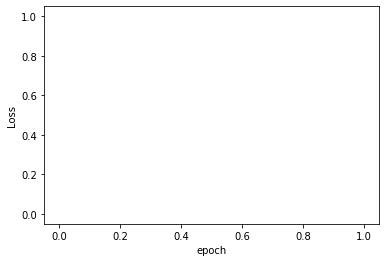

In [1007]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

---

#### Label Ranking Policy

In [821]:
env = gym.make('CartPole-v0')
observation = env.reset()

state_obs = observation[[2,3]] # only select angel and angular velo. of pendulum from state vector
state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
state_obs = torch.from_numpy(state_obs) # convert to a tensor

# make the prediction for actions
with torch.no_grad():
    preds = model(state_obs.float()) 
    
# rank the indexes of actions (from highest ranked/preferred action to lowest)
ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

# return the action value
remain_probs = .1/len(ranked_action_idx[2:])
n_remain_actions = ranked_action_idx.shape[0]-2

# - select first two (highest preferred actions) 80% and 10% of the time
# - select one of the remaining actions 10% time
action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1] + list(np.repeat(remain_probs,n_remain_actions)))[0]

action

0

---

### Visualize episode

##### METHOD 1:

In [70]:
env = gym.make('MountainCar_PbPI_Version-v0')
env = wrappers.Monitor(env, "./gym-results/mount-car", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(random_action(env))
    if done: break
env.close()

video = io.open('./gym-results/mount-car/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

##### METHOD 2:

TypeError: Image data of dtype object cannot be converted to float

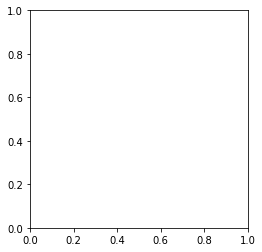

In [1077]:
nb_episodes = 20
nb_timesteps = 100
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for episode in range(nb_episodes):  # iterate over the episodes
    state = env.reset()             # initialise the environment
    rewards = []
    
    for t in range(nb_timesteps):    # iterate over time steps
        #env.render()                 # display the environment
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, info = env.step(0)  # implement the action chosen by the policy
        rewards.append(reward)      # add 1 to the rewards list
        
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            cumulative_reward = sum(rewards)
            print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward))  
            break
    
env.close()

---

##### OTHER USEFUL-INFO: